# Importing librairies

In [1]:
# Environment
import gymnasium as gym
import highway_env

# Models and computation
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
from collections import namedtuple, deque
import random
# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import trange
from config_parking import config

# IO
from pathlib import Path

import sys
import pandas as pd

In [2]:
env = gym.make("parking-v0", render_mode="rgb_array")

In [3]:
env.unwrapped.configure(config)

# Video recording

In [4]:
import cv2
import gym
from pathlib import Path
import numpy as np
from IPython.display import HTML
from base64 import b64encode

class RecordVideos(gym.Wrapper):
    def __init__(self, env, save_dir="videos", fps=20):
        super().__init__(env)
        self.frames = []
        self.save_dir = Path(save_dir)
        self.fps = fps
        self.save_dir.mkdir(parents=True, exist_ok=True)
        self.video_path = None

    def reset(self, **kwargs):
        self.frames = []
        return super().reset(**kwargs)

    def step(self, action):
        observation, reward, done, truncated, info = super().step(action)
        self.frames.append(self.env.render())
        return observation, reward, done, truncated, info

    def close(self):
        if self.frames:
            self.save_video()
        super().close()

    def save_video(self):
        video_id = len(list(self.save_dir.glob("*.avi"))) + 1
        self.video_path = self.save_dir / f"episode_{video_id}.avi"
        frame_size = (self.frames[0].shape[1], self.frames[0].shape[0])
        out = cv2.VideoWriter(str(self.video_path), cv2.VideoWriter_fourcc(*'DIVX'), self.fps, frame_size)
        for frame in self.frames:
            out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        out.release()

def record_videos(env):
    return RecordVideos(env)


# Ornstein-Ulhenbeck Process and Memory

In [5]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        """
        Initialize the Ornstein-Ulhenbeck Noise.

        Args:
            action_space: The action space of the environment.
            mu (float): The long-running mean of the noise.
            theta (float): The speed of mean reversion.
            max_sigma (float): The maximum standard deviation of the noise.
            min_sigma (float): The minimum standard deviation of the noise.
            decay_period (int): The period over which to decay the noise.
        """
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        """Reset the internal state to the initial mean."""
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        """
        Evolve the internal state using the Ornstein-Ulhenbeck process.

        Returns:
            np.ndarray: The new state of the noise.
        """
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        """
        Add noise to the given action.

        Args:
            action: The original action.
            t (int): The current timestep.

        Returns:
            np.ndarray: The noisy action.
        """
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def _action(self, action):
        """
        Scale the action to match the environment's action space.

        Args:
            action: The original action.

        Returns:
            np.ndarray: The scaled action.
        """
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def _reverse_action(self, action):
        """
        Reverse the scaling of the action.

        Args:
            action: The scaled action.

        Returns:
            np.ndarray: The original action.
        """
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)
        

class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)


# Actor-Critic
The Critic and Actor classes define the neural network architectures for the Critic, representing the value function, and the Actor, representing the policy function, respectively. The Critic takes the current state and action as input, passes them through layers with ReLU activation functions, and produces the estimated value of the state-action pair. The Actor takes the current state as input, passes it through layers with ReLU activation functions, and outputs the action to be taken, bounded between -1 and 1. Together, these classes form the Actor-Critic architecture, integrating value-based and policy-based reinforcement learning methods for efficient learning and decision-making.

In [6]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, state):
        """
        Param state is a torch tensor
        """
        
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

# DDPG agent
The Deep Deterministic Policy Gradient (DDPG) algorithm is a powerful reinforcement learning technique designed for solving continuous action space problems. It combines the benefits of deep neural networks with the deterministic policy gradient theorem to learn policies in high-dimensional action spaces. 

In DDPG, there are two main components: the Actor and the Critic. The Actor is responsible for learning the policy function, which directly maps states to actions. It typically uses a deep neural network to approximate this mapping, enabling it to handle complex and continuous action spaces. The Critic, on the other hand, evaluates the actions taken by the Actor by estimating the action-value function. It learns to predict the expected cumulative reward from a given state-action pair.

During training, the Actor and Critic networks interact with the environment to collect experience tuples consisting of states, actions, rewards, and next states. These experiences are stored in a replay buffer, which is then sampled to train the networks. The Critic is trained using temporal difference learning to minimize the mean squared error between predicted and target action values. The Actor is trained using the deterministic policy gradient, aiming to maximize the expected cumulative reward.

DDPG also employs target networks to stabilize training. These networks are copies of the Actor and Critic networks, periodically updated with soft target updates to track the learned policies and value functions more slowly.

Overall, DDPG is well-suited for tasks with continuous action spaces, such as robotic control, autonomous driving, and many others, and has been successfully applied to various challenging reinforcement learning problems.

In [7]:
class DDPGagent:
    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=0.005, max_memory_size=50000):
        """
        Initialize the DDPG agent.

        Args:
            env (gym.Env): The Gym environment.
            hidden_size (int): The size of the hidden layers in the neural networks.
            actor_learning_rate (float): The learning rate for the actor network.
            critic_learning_rate (float): The learning rate for the critic network.
            gamma (float): The discount factor for future rewards.
            tau (float): The soft update rate for the target networks.
            max_memory_size (int): The maximum size of the replay buffer.
        """
        # Parameters
        self.num_states = env.observation_space.spaces["observation"].shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        # Initialize target networks with same weights as main networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training setup
        print("Training")
        self.memory = Memory(max_memory_size)
        self.critic_criterion = nn.MSELoss()
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
    
    def get_action(self, state):
        """
        Get action for given state using the actor network.

        Args:
            state (np.ndarray): The current state.

        Returns:
            float: The action selected by the actor network.
        """
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0, 0]
        return action
    
    def update(self, batch_size):
        """
        Perform a gradient update for both actor and critic networks.

        Args:
            batch_size (int): The size of the batch sampled from the replay buffer.
        """
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
    
        # Critic loss        
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        # Update actor network
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        # Update critic network
        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()

        # Update target networks with soft updates
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))


# Training the Agent

training


c:\Users\oumai\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\oumai\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


episode: 0, reward: -44.79, average_reward: nan
episode: 1, reward: -17.91, average_reward: -44.78658718625349
episode: 2, reward: -21.34, average_reward: -31.346050037426775
episode: 3, reward: -16.41, average_reward: -28.00950718597096


C:\Users\oumai\AppData\Local\Temp\ipykernel_3428\2175684583.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  states = torch.FloatTensor(states)


episode: 4, reward: -21.8, average_reward: -25.109746862443604
episode: 5, reward: -24.23, average_reward: -24.447709963507354
episode: 6, reward: -26.55, average_reward: -24.4113185893123
episode: 7, reward: -23.08, average_reward: -24.717553558562027
episode: 8, reward: -35.52, average_reward: -24.512838452217295
episode: 9, reward: -63.31, average_reward: -25.7361456106264
episode: 10, reward: -52.31, average_reward: -29.493758292920518
episode: 11, reward: -13.87, average_reward: -30.24624929629808
episode: 12, reward: -61.24, average_reward: -29.84249774382493
episode: 13, reward: -16.77, average_reward: -33.83284282293875
episode: 14, reward: -15.68, average_reward: -33.869287896767084
episode: 15, reward: -16.5, average_reward: -33.257560707780456
episode: 16, reward: -12.69, average_reward: -32.48506661282707
episode: 17, reward: -31.21, average_reward: -31.098132097945268
episode: 18, reward: -59.31, average_reward: -31.911381053234418
episode: 19, reward: -35.92, average_rewa

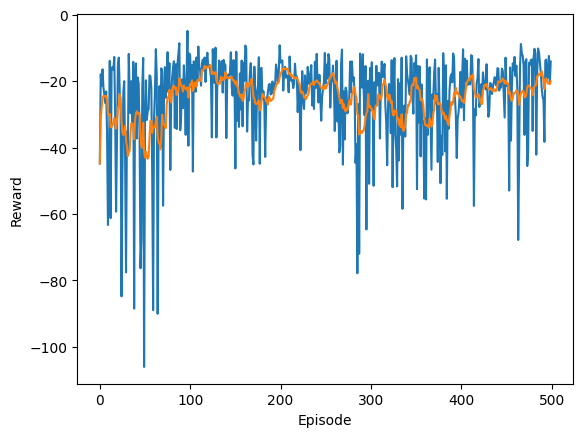

In [8]:
# Setup environment and wrappers
env = record_videos(env)  # Wrap the environment to enable video recording

agent = DDPGagent(env)
noise = OUNoise(env.action_space)
batch_size = 256
rewards = []
avg_rewards = []

for episode in range(500):
    state = env.reset()[0]
    noise.reset()
    episode_reward = 0
    for step in range(500):
        action = agent.get_action(state['observation'])
        action = noise.get_action(action, step)
        new_state, reward, done, _, _ = env.step(action)
        agent.memory.push(state['observation'], action, reward, new_state['observation'], done)
        if len(agent.memory) > batch_size:
            agent.update(batch_size)        
        state = new_state
        episode_reward += reward
        if done:
            sys.stdout.write(f"episode: {episode}, reward: {np.round(episode_reward, decimals=2)}, average_reward: {np.mean(rewards[-10:])}\n")
            break
    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

plt.plot(rewards)
plt.plot(avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

env.close()